## Response Ranking

In [80]:
from __future__ import print_function
import os
import datetime, time, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False # Disable the warnings
tf.get_logger().setLevel('ERROR')
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, BatchNormalization, Dot, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import logging
logging.getLogger('tensorflow').disabled = True #OPTIONAL - to disable outputs from Tensorflow

np.random.seed(10)

In [81]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-qa/3")

In [82]:
rr_df = pd.read_csv('data/rr_data_100k.csv')
#rr_df = pd.read_csv('data/rr_data_30k.csv')
rr_df.dropna(inplace=True)
rr_df.shape

(96367, 3)

In [83]:
rr_df.head()

,body,answer,accepted_flag
0,understand modular arithmetic basic mathematic...,mod operator used many different ways case use...,0
1,understand modular arithmetic basic mathematic...,modular 127 us ensure stay ascii bounds basica...,0
2,understand modular arithmetic basic mathematic...,parts,1
3,running numerical simulations main function mu...,could pass dictionary like,0
4,running numerical simulations main function mu...,nt think really stackoverflow question softwar...,1


In [84]:
y = rr_df['accepted_flag'].to_numpy()

In [85]:
print(y.shape)

(96367,)


In [86]:
rr_df.head()

,body,answer,accepted_flag
0,understand modular arithmetic basic mathematic...,mod operator used many different ways case use...,0
1,understand modular arithmetic basic mathematic...,modular 127 us ensure stay ascii bounds basica...,0
2,understand modular arithmetic basic mathematic...,parts,1
3,running numerical simulations main function mu...,could pass dictionary like,0
4,running numerical simulations main function mu...,nt think really stackoverflow question softwar...,1


In [87]:
X = rr_df.to_numpy()

In [88]:
print(X.shape)

(96367, 3)


### Build a Train and Test Dataset

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)
print("X_train", X_train.shape)
print("Y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (77093, 3)
Y_train (77093,)
X_test (19274, 3)
y_test (19274,)


In [90]:
Q_train = X_train[:,0]
A_train = X_train[:,1]
print(Q_train.shape, A_train.shape,y_train.shape)

(77093,) (77093,) (77093,)


In [91]:
Q_test = X_test[:,0]
A_test = X_test[:,1]
print(Q_test.shape, A_test.shape,y_test.shape)

(19274,) (19274,) (19274,)


In [92]:
print(Q_train[:3],"--", A_train[:3])

['data following form'
 'whatever integer input always turns thatman need learn print number first nt work thank guys'
 'new scikit playing around'] -- ['using could say awk 1 prevnextprev11 inputfile' 'also use try excepts'
 'function returns array object stated documentation array object corresponds indices labels array get prediction line need try something like print labelspredicted']


### Utilities

In [93]:
def plot_model(model_name, hist):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title(model_name + 'model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title(model_name + 'model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Models

### Baseline Cosine Similarity

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

In [49]:
Q_train_lst = Q_train.tolist()
A_train_lst = A_train.tolist()

In [50]:
X_train_ue = []

for i in range(len(Q_train_lst)):
    q = [Q_train[i]]
    a = [A_train[i]]
    X_train_ue.append(cosine_similarity(embed(tf.cast(q, tf.string)), embed(tf.cast(a, tf.string))))

In [61]:
print(X_train_ue[0])

[[0.08030646]]


In [51]:
X_train_ue_np = np.array(X_train_ue) 
X_train_ue_np = X_train_ue_np[:, 0]

In [59]:
print(X_train_ue_np)

[[ 0.08030646]
 [-0.01254405]
 [ 0.27926126]
 ...
 [ 0.07704539]
 [ 0.3592642 ]
 [ 0.3816369 ]]


In [52]:
clf = LogisticRegression(random_state=0).fit(X_train_ue_np, y_train)

/home/rahul_kulkarni/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
Q_test_lst = Q_test.tolist()
A_test_lst = A_test.tolist()

In [54]:
X_test_ue = []
for i in range(len(Q_test_lst)):
    q = [Q_test[i]]
    a = [A_test[i]]
    X_test_ue.append(cosine_similarity(embed(tf.cast(q, tf.string)), embed(tf.cast(a, tf.string))))

In [55]:
X_test_ue_np = np.array(X_test_ue)
X_test_ue_np = X_test_ue_np[:, 0]

In [146]:
clf.score(X_test_ue_np, y_test)

NameError: name 'clf' is not defined

### Two Tower Model

In [17]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string), axis=1))

In [28]:
USE_EMBEDDING_SIZE = 512
VALIDATION_SPLIT = 0.1
DROPOUT = 0.2
BATCH_SIZE = 50
MODEL_WEIGHTS_FILE = 'data/coda_twotower_model'

from tensorflow.keras.optimizers import Adam

def build_model_two_tower(activation_function='relu', 
                  optimizer='adam', 
                  #kernel_initializer=tf.keras.initializers.he_normal(seed=1), 
                  #bias_initializer='zeros',
                  dropout=0.2):

    # Define Input Layer
    Q_s = Input(shape=(1,), dtype="string")
    
    A_s = Input(shape=(1,), dtype="string")
        
    # Define an embedding layer using USE
    Q_e = Lambda(UniversalEmbedding, output_shape=(USE_EMBEDDING_SIZE, ))(Q_s)
    
      # Define an embedding layer using USE
    A_e = Lambda(UniversalEmbedding, output_shape=(USE_EMBEDDING_SIZE, ))(A_s)
    
    # Define one hidden layer
    dense_layer = Dense(1024, 
                        activation=activation_function,
                        #kernel_initializer=kernel_initializer, 
                        #bias_initializer=bias_initializer,
                        name='layer-1')
    
    # Feed the answer embedding to a dense layer
    A_prime = dense_layer(A_e)
    #A_prime = Dropout(dropout)(A_prime)
    #A_prime = BatchNormalization()(A_prime)
    
    # Define a second hidden layer
    dense_layer_2 = Dense(512,
                          activation=activation_function,
                          #kernel_initializer=kernel_initializer, 
                          #bias_initializer=bias_initializer,
                          name='layer-2')
    
    # Feed the previous layer output to dense 2 layer               
    A_prime = dense_layer_2(A_prime)
    #A_prime = Dropout(dropout)(A_prime)
    #A_prime = BatchNormalization()(A_prime)
    
    # Dot product of Question Embedding and Answer prime
    QA = Dot(axes = 1)([Q_e,A_prime])
    
    result = Reshape((1,), input_shape=(1,1))(QA)
    
    # Final layer
    probs  = Dense(1, activation='sigmoid')(result)

    # Build and compile model, input Question and Answer body 
    two_tower_model = Model(inputs=[Q_s, A_s], outputs=probs)
    
    opt = Adam(lr=5e-5)
    
    two_tower_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return two_tower_model

In [29]:
two_tower_model = build_model_two_tower()

two_tower_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
layer-1 (Dense)                 (None, 1024)         525312      lambda_3[0][0]                   
____________________________________________________________________________________________

#### Train and Evaluate the model

In [30]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True), 
             EarlyStopping(monitor='val_loss', patience=3)]
history_tt = two_tower_model.fit([Q_train, A_train], 
                                 y_train, 
                                 epochs=10,
                                 validation_split=VALIDATION_SPLIT,
                                 verbose=2,
                                 batch_size=BATCH_SIZE,
                                 callbacks=callbacks)
two_tower_model.save_weights(MODEL_WEIGHTS_FILE)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-04-19 00:18:44.021688
Train on 209 samples, validate on 24 samples
Epoch 1/10
209/209 - 43s - loss: 0.6912 - accuracy: 0.5263 - val_loss: 0.6859 - val_accuracy: 0.6667
Epoch 2/10
209/209 - 1s - loss: 0.6632 - accuracy: 0.6651 - val_loss: 0.6814 - val_accuracy: 0.6667
Epoch 3/10
209/209 - 1s - loss: 0.6348 - accuracy: 0.6603 - val_loss: 0.6786 - val_accuracy: 0.6667
Epoch 4/10
209/209 - 1s - loss: 0.6024 - accuracy: 0.6746 - val_loss: 0.6851 - val_accuracy: 0.6250
Epoch 5/10
209/209 - 1s - loss: 0.5681 - accuracy: 0.7368 - val_loss: 0.6955 - val_accuracy: 0.6250
Epoch 6/10
209/209 - 1s - loss: 0.5369 - accuracy: 0.7751 - val_loss: 0.7167 - val_accuracy: 0.6250
Training ended at 2020-04-19 00:19:33.875797
Minutes elapsed: 0.830896


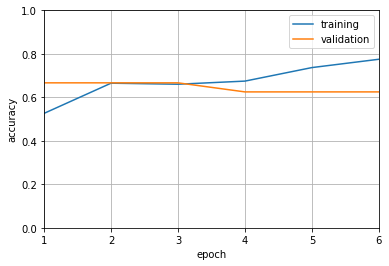

In [31]:
#print(history.history.keys())
acc = pd.DataFrame({'epoch': [ i + 1 for i in history_tt.epoch ],
                    'training': history_tt.history['accuracy'],
                    'validation': history_tt.history['val_accuracy']})
ax = acc.plot(x='epoch', grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

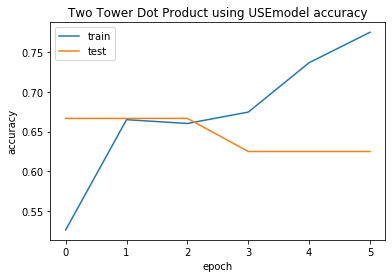

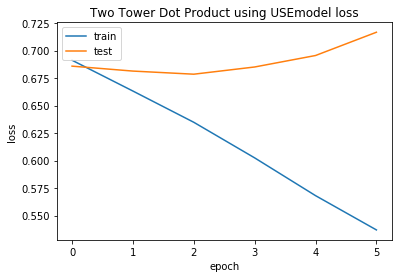

In [32]:
plot_model("Two Tower Dot Product using USE", history_tt)

In [33]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history_tt.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 3 = 0.6667


In [34]:
two_tower_model.load_weights(MODEL_WEIGHTS_FILE)  
predicts = two_tower_model.predict([Q_test, A_test])
print('\n# Evaluate on test data')
results_tt = two_tower_model.evaluate([Q_test, A_test], y_test)
print('test loss, test acc:', results_tt)


# Evaluate on test data
59/59 [==============================] - 0s 5ms/sample - loss: 0.7104 - accuracy: 0.6102
test loss, test acc: [0.7103515772496239, 0.6101695]


### Cross Attention Model

In [94]:
X_train = X_train[:,0] + X_train[:,1].astype('str')
print("X_train Concatenated with Q, A", X_train.shape)
X_test = X_test[:,0] + X_test[:,1].astype('str')
print("X_test  Concatenated with Q, A", X_test.shape)

X_train Concatenated with Q, A (77093,)
X_test  Concatenated with Q, A (19274,)


In [28]:
USE_EMBEDDING_SIZE = 512
VALIDATION_SPLIT = 0.1
DROPOUT = 0.2
BATCH_SIZE = 32
MODEL_WEIGHTS_FILE = 'data/coda_rr_crossattn_model'

def build_model_cross_attn(activation_function='relu', 
                  optimizer='adam', 
                  #kernel_initializer=tf.keras.initializers.he_normal(seed=1), 
                  #bias_initializer='zeros',
                  dropout=0.2):

    # Define Input Layer
    input_text = Input(shape=(1,), dtype="string")
    
    # Define an embedding layer using USE
    embedding = Lambda(UniversalEmbedding, output_shape=(USE_EMBEDDING_SIZE, ))(input_text)
    
    # Define one hidden layer
    dense_layer = Dense(1024, 
                          activation=activation_function,
                          #kernel_initializer=kernel_initializer, 
                          #bias_initializer=bias_initializer,
                          name='layer-1')
    
    # Feed the embeddings to the dense layer
    dense_output = dense_layer(embedding)
    
    # Use dropout to avoid overfit 
    dropout_output = Dropout(dropout)(dense_output)

    #Batch normalize
    batchnormalized_output = BatchNormalization()(dropout_output)
    
    # Define a second hidden layer
    dense_layer_2 = Dense(512,
                          activation=activation_function,
                          #kernel_initializer=kernel_initializer, 
                          #bias_initializer=bias_initializer,
                          name='layer-2')
    
    # Feed the previous layer output to dense 2 layer                
    dense_output_2 = dense_layer_2(batchnormalized_output)
    
    # Use dropout to avoid overfit 
    dropout_output_2 = Dropout(dropout)(dense_output_2)
    
    #Batch normalize
    batchnormalized_output_2 = BatchNormalization()(dropout_output_2)
    
    # Final sigmoid layer for prediction probablities
    pred = Dense(1, activation='sigmoid')(batchnormalized_output_2)
    
    # Build and compile model
    model_cross_attn = Model(inputs=[input_text], outputs=pred)
    
    model_cross_attn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model_cross_attn


In [29]:
model_cross_attn = build_model_cross_attn()

model_cross_attn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
layer-1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
layer-2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [23]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=3)]

history_ca = model_cross_attn.fit(X_train, 
                                  y_train, 
                                  epochs=10,
                                  validation_split=VALIDATION_SPLIT,
                                  verbose=2,
                                  batch_size=BATCH_SIZE,
                                  callbacks=callbacks)
model_cross_attn.save_weights(MODEL_WEIGHTS_FILE)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-04-17 06:26:36.690541
Train on 69383 samples, validate on 7710 samples
Epoch 1/10


/home/rahul_kulkarni/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/rahul_kulkarni/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


69383/69383 - 717s - loss: 0.6490 - accuracy: 0.6405 - val_loss: 0.6461 - val_accuracy: 0.6433
Epoch 2/10
69383/69383 - 697s - loss: 0.6460 - accuracy: 0.6413 - val_loss: 0.6459 - val_accuracy: 0.6425
Epoch 3/10
69383/69383 - 707s - loss: 0.6436 - accuracy: 0.6422 - val_loss: 0.6489 - val_accuracy: 0.6363
Epoch 4/10
69383/69383 - 665s - loss: 0.6392 - accuracy: 0.6447 - val_loss: 0.6509 - val_accuracy: 0.6355
Epoch 5/10
69383/69383 - 684s - loss: 0.6306 - accuracy: 0.6493 - val_loss: 0.6611 - val_accuracy: 0.6220
Training ended at 2020-04-17 07:24:27.603130
Minutes elapsed: 57.848538


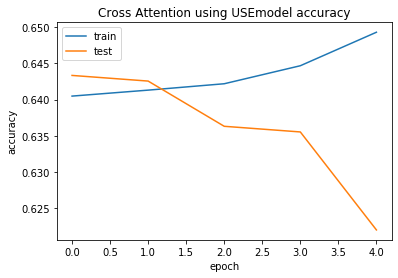

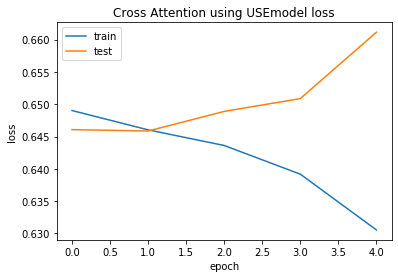

In [24]:
plot_model("Cross Attention using USE", history_ca)

In [25]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history_ca.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 1 = 0.6433


In [26]:
model_cross_attn.load_weights(MODEL_WEIGHTS_FILE)  
predicts = model_cross_attn.predict([Q_test, A_test])
print('\n# Evaluate on test data')
results = model_cross_attn.evaluate([Q_test, A_test], y_test)
print('test loss, test acc:', results)


# Evaluate on test data
19274/19274 [==============================] - 95s 5ms/sample - loss: 0.6737 - accuracy: 0.6183
test loss, test acc: [0.6737244157446263, 0.618346]


In [95]:
import bert
from bert.tokenization.bert_tokenization import FullTokenizer
import sys
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from collections import namedtuple
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.1.0
Hub version:  0.8.0


In [96]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

In [97]:
MAX_SEQ_LEN=128
BATCH_SIZE=200
VALIDATION_SPLIT=0.1
DROPOUT=0.2
#MODEL_WEIGHTS_FILE="gdrive/My Drive/Colab Notebooks/coda/data/CODA_QS_BERT"
MODEL_WEIGHTS_FILE="data/CODA_SS_BERT"

def build_bert_model(activation_function='relu', 
                     optimizer='adam', 
                     dropout=0.2):

    input_word_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    # Final sigmoid layer for prediction probablities
    pred = Dense(1, activation='sigmoid')(pooled_output)
    
    bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)
    
    opt = Adam(lr=5e-5)
    
    bert_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return bert_model

In [98]:
bert_model = build_bert_model()

bert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [99]:
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

In [100]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [101]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [102]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

In [103]:
def create_input_array(sentences):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [104]:
inputs=create_input_array(X_train)

100%|██████████| 77093/77093 [01:06<00:00, 1156.06it/s]


In [105]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True), 
             EarlyStopping(monitor='val_loss', patience=2)]
history_bert = bert_model.fit(inputs, 
                              y_train, 
                              epochs=2,
                              validation_split=VALIDATION_SPLIT,
                              verbose=2,
                              batch_size=BATCH_SIZE,
                              callbacks=callbacks)
bert_model.save_weights(MODEL_WEIGHTS_FILE)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-04-19 01:49:46.471149
Train on 69383 samples, validate on 7710 samples
Epoch 1/2
69383/69383 - 10816s - loss: 0.6498 - accuracy: 0.6399 - val_loss: 0.6420 - val_accuracy: 0.6435
Epoch 2/2
69383/69383 - 10732s - loss: 0.6356 - accuracy: 0.6418 - val_loss: 0.6419 - val_accuracy: 0.6301
Training ended at 2020-04-19 07:49:06.611691
Minutes elapsed: 359.335670


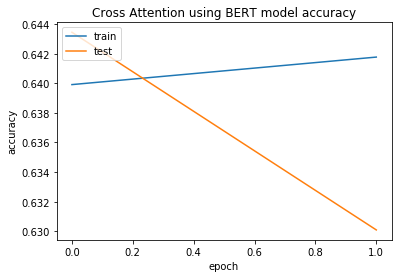

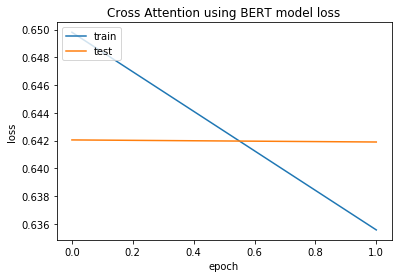

In [106]:
plot_model("Cross Attention using BERT ", history_bert)

In [107]:
inputs=create_input_array(X_test)
bert_model.load_weights(MODEL_WEIGHTS_FILE)  
predicts = bert_model.predict(inputs)
print('\n# Evaluate on test data')
results = bert_model.evaluate(inputs, y_test)
print('test loss, test acc:', results)

100%|██████████| 19274/19274 [00:16<00:00, 1175.45it/s]



# Evaluate on test data
19274/19274 [==============================] - 981s 51ms/sample - loss: 0.6429 - accuracy: 0.6294
test loss, test acc: [0.6429365491414325, 0.629449]


### Analyze the low accuracy for response ranking

(array([ 399.,  680., 2368., 4543., 3932., 2629., 2621., 2049.,   40.,
          13.]),
 array([0.1012755 , 0.16189715, 0.2225188 , 0.28314045, 0.3437621 ,
        0.40438375, 0.4650054 , 0.525627  , 0.5862487 , 0.6468704 ,
        0.707492  ], dtype=float32),
 <a list of 10 Patch objects>)

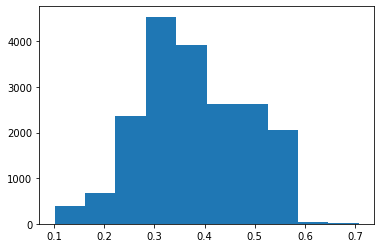

In [150]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

plt.hist(predicts)

(array([12344.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6930.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

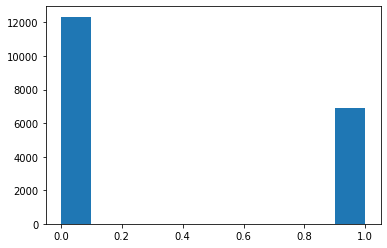

In [145]:
plt.hist(y_test)

(array([15920.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3354.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

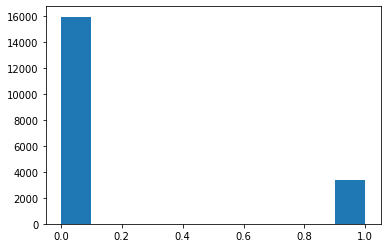

In [143]:
y_pred_bool = (predicts>0.5).astype(int)
plt.hist(y_pred_bool)

In [148]:
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.66      0.86      0.75     12344
           1       0.47      0.23      0.31      6930

    accuracy                           0.63     19274
   macro avg       0.57      0.54      0.53     19274
weighted avg       0.59      0.63      0.59     19274



In [158]:
print(confusion_matrix(y_test, y_pred_bool))

[[10561  1783]
 [ 5359  1571]]


In [164]:
print(y_test.shape)

(19274,)


In [166]:
y_pred_bool = y_pred_bool.flatten()

In [167]:
unique_label = np.unique([y_test, y_pred_bool])
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred_bool, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)
print(cmtx)

        pred:0  pred:1
true:0   10561    1783
true:1    5359    1571


In [202]:
x = y_test != y_pred_bool.astype(int).flatten()

In [206]:
index = np.asarray(np.where(x))

In [222]:
sample = (index[0][50:1000:10])

In [223]:
print("Print few incorrect predictions\n")
for i in sample:
    print(X_test[i], y_test[i])
    print("\n")

Print few incorrect predictions

problem replacement values column conditional two columnsthink need check trues per rows assign output filtered dataframe boolean mask data1 pd dataframe c payrollotherpayrollsocial true true true false bfalse true true false print data1 b c 0 true false payroll 1 true true 2 true true payroll 3 false false social data1a ballaxis1 output data1a data1b print 0 false 1 true 2 true 3 false dtype bool print data1m b c 1 true true 2 true true payroll 1


working create file sharing platform open source software pythonmethod exposed create magnet uri directly link would unusable 1


assign columns dataframe equal another column condition metwork row wise 1


trying load matplotlib object reportlab codesole reason pdfrw example discussed first answer question bit klunky pdfrw documentation sucks badly due sucky doc example author larry meyn used vectorpdf extension rst2pdf starting point extension really documented either deal quirks rst2pdf well pdfrw general